In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

(<Figure size 350x262.5 with 1 Axes>, <AxesSubplot: >)

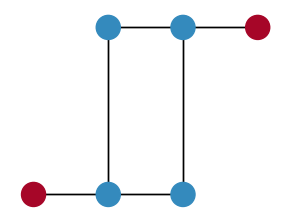

In [237]:
# Example: Cubic Network
network_topology = "cubic"

# Network Parameter
topology_parameter = {
    "Nx"    : 2,
    "Ny"    : 2,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[1,1,0]]
}

# Network Class Object
np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)
nanonets_utils.display_network(np_network_cubic)

In [239]:
voltages        = np.zeros(shape=(100,3))
voltages[:,0]   = np.linspace(-0.2,0.2,100)

np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)
np_network_cubic.run_const_voltages(voltages=voltages, target_electrode=1, save_th=0.1, jumps_per_stat=100, output_potential=False)

In [240]:
df      = pd.DataFrame(np.hstack((voltages,np_network_cubic.return_output_values())))
df[7]   = np_network_cubic.return_potential_landscape()[:,5]
df

,0,1,2,3,4,5,6,7
0,-0.200000,0.0,0.0,100000.0,1000.0,-12126.059254,548.689050,-0.058930
1,-0.195960,0.0,0.0,100000.0,200.0,-11287.761841,11.534683,-0.058634
2,-0.191919,0.0,0.0,100000.0,800.0,-11507.682470,531.902193,-0.052435
3,-0.187879,0.0,0.0,100000.0,200.0,-9137.310192,80.620768,-0.057959
4,-0.183838,0.0,0.0,100000.0,200.0,-10731.790280,381.676705,-0.046913
...,...,...,...,...,...,...,...,...
95,0.183838,0.0,0.0,100000.0,200.0,9818.175089,43.542395,0.063977
96,0.187879,0.0,0.0,100000.0,300.0,11924.484746,572.815038,0.046842
97,0.191919,0.0,0.0,100000.0,500.0,11715.446019,551.485438,0.055120
98,0.195960,0.0,0.0,100000.0,700.0,11770.022188,582.018781,0.061173


In [246]:
def pot_current_dep(voltages, n_jumps=10000):

    pot_landscape   = np.zeros(n_jumps)
    time_vals       = np.zeros(n_jumps)
    pos_jumps       = np.zeros(n_jumps)
    neg_jumps       = np.zeros(n_jumps)

    np_network_cubic    = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)

    # Based on current voltages get charges and potentials
    np_network_cubic.init_charge_vector(voltages)
    np_network_cubic.init_potential_vector(voltages)
    np_network_cubic.init_const_capacitance_values()
    np_network_cubic.np_target_electrode_electrostatic_properties(1)

    # Return Model Arguments
    inv_capacitance_matrix                                                                  = np_network_cubic.return_inv_capacitance_matrix()
    charge_vector                                                                           = np_network_cubic.return_charge_vector()
    potential_vector                                                                        = np_network_cubic.return_potential_vector()
    const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2    = np_network_cubic.return_const_capacitance_values()
    N_electrodes, N_particles                                                               = np_network_cubic.return_particle_electrode_count()
    adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2, co_adv_index3             = np_network_cubic.return_advanced_indices()
    temperatures, temperatures_co                                                           = np_network_cubic.return_const_temperatures(T=0.0)
    resistances, resistances_co1, resistances_co2                                           = np_network_cubic.return_random_resistances(R=np_network_cubic.res_info['mean_R'], Rstd=np_network_cubic.res_info['std_R'])
    idx_np_target, C_np_self, C_np_target                                                   = np_network_cubic.return_output_electrostatics()

    # Pass all model arguments into Numba optimized Class
    model = nanonets.model_class(charge_vector, potential_vector, inv_capacitance_matrix, const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2,
                            temperatures, temperatures_co, resistances, resistances_co1, resistances_co2, adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2,
                            co_adv_index3, N_electrodes, N_particles, C_np_target, C_np_self)
    
    model.calc_potentials()

    for i in range(1000):
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        model.calc_tunnel_rates_zero_T()
        model.select_event(random_number1, random_number2)

    model.time = 0.0

    for i in range(n_jumps):

        t1 = model.time
        
        pot_landscape[i]= model.potential_vector[5]
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        model.calc_tunnel_rates_zero_T()
        model.select_event(random_number1, random_number2)

        np1 = model.adv_index_rows[model.jump]
        np2 = model.adv_index_cols[model.jump]

        # If jump from target electrode
        if (np1 == 1):
            neg_jumps[i] = 1
            
        # If jump towards target electrode
        if (np2 == 1):
            pos_jumps[i] = 1
        
        t2 = model.time

        time_vals[i] = t2-t1
    
    return pd.DataFrame((np.array(pot_landscape),np.array(time_vals),pos_jumps-neg_jumps)).T

In [247]:
voltages    = np.array([0.2,0.0,0.0])
n_jumps     = 100000
df          = pot_current_dep(voltages, n_jumps)
df

,0,1,2
0,0.069388,1.711639e-12,1.0
1,0.049110,1.519004e-11,0.0
2,0.051946,1.459393e-10,0.0
3,0.068022,2.295395e-13,1.0
4,0.047743,4.547584e-11,0.0
...,...,...,...
99995,0.070755,4.713333e-12,0.0
99996,0.072122,7.303312e-11,0.0
99997,0.073489,1.684364e-11,0.0
99998,0.076325,5.398647e-13,0.0


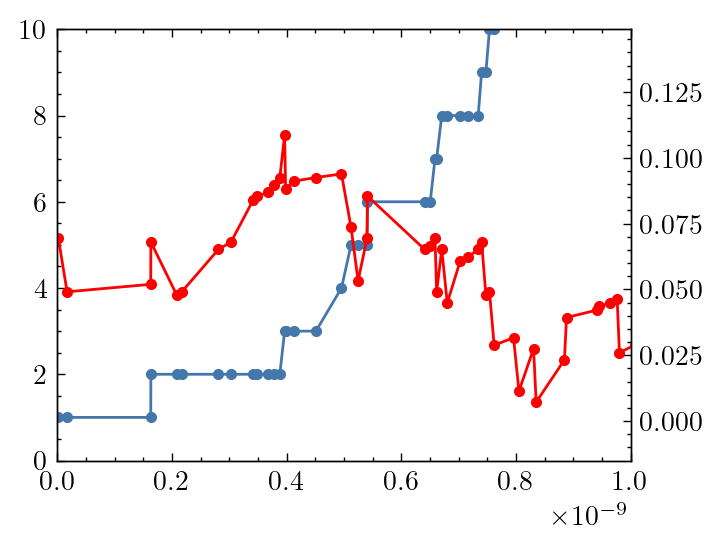

In [271]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200,layout='constrained')
    ax  = fig.add_subplot()
    ax.plot(np.cumsum(df[1]), np.cumsum(df[2]), '.-')
    ax.set_xlim(0,1e-9)
    ax.set_ylim(0,10)

    ax2 = ax.twinx()
    ax2.plot(np.cumsum(df[1]), df[0], '.-', c='red')
    ax2.set_xlim(0,1e-9)

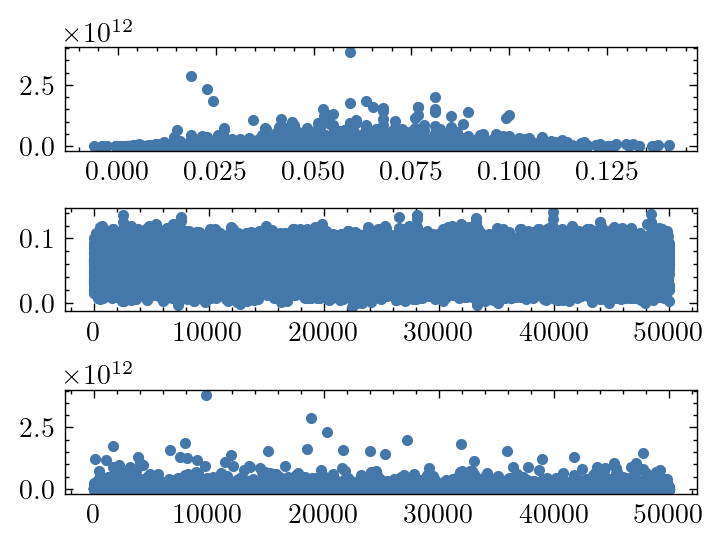

In [250]:
vals_per_bin    = 2
df[3]           = np.repeat(np.arange(1,n_jumps/vals_per_bin+1),vals_per_bin)
df_bins         = df[[0,3]].groupby(by=3).mean()
df_bins[1]      = df[[2,3]].groupby(by=3).sum()[2]/df[[1,3]].groupby(by=3).sum()[1]

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200,layout='constrained')
    ax  = fig.add_subplot(3,1,1)
    ax.plot(df_bins[0], df_bins[1], '.')

    ax  = fig.add_subplot(3,1,2)
    ax.plot(df_bins[0], '.')

    ax  = fig.add_subplot(3,1,3)
    ax.plot(df_bins[1], '.')